![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 07. <i>Analiza wideo: przepływ optyczny, śledzenie obiektów</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/aitech-wko-pub

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/aitech-wko-pub


W poniższych materiałach zobaczymy w jaki sposób możemy przy pomocy przepływu optycznego dokonać stabilizacji obrazu oraz w jaki sposób śledzić obiekty znajdujące się na filmie.

Na początku załadujmy niezbędne biblioteki.

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

# Przepływ optyczny

Naszym celem będzie znalezienie na poniższym filmie punktów kluczowych, które pozwolą nam w jakiś sposób sprawdzić jak przemieszcza się rowerzystka:

In [4]:
IPython.display.Video("vid/bike.mp4", width=800)

Załadujmy film:

In [5]:
bike = cv.VideoCapture("vid/bike.mp4")

Przy pomocy algorytmu Shi-Tomasi (rozwinięcie metody Harrisa) możemy znaleźć narożniki, które dobrze nadają się do śledzenia. W OpenCV algorytm jest zaimplementowany w funkcji [`cv.goodFeaturesToTrack()`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541):

In [6]:
corners_num = 100
corners_colors = np.random.randint(0, 255, (corners_num, 3))

_, frame_1 = bike.read()
frame_1_gray = cv.cvtColor(frame_1, cv.COLOR_BGR2GRAY)
keypoints_1 = cv.goodFeaturesToTrack(
    frame_1_gray, mask=None, maxCorners=corners_num,
    qualityLevel=0.3, minDistance=7, blockSize=7)

mask = np.zeros_like(frame_1)
count = 0

Aby sprawdzić w jaki sposób punkty przemieszczają się pomiędzy kolejnymi klatkami filmu, wykorzystamy algorytm Lucasa–Kanade, który jest zaimplementowany w funkcji [`cv.calcOpticalFlowPyrLK()`](https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323):

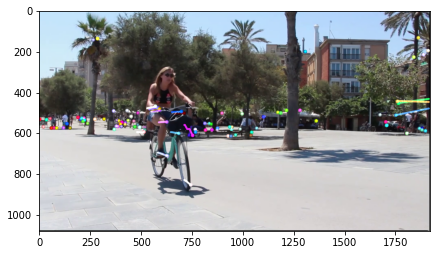

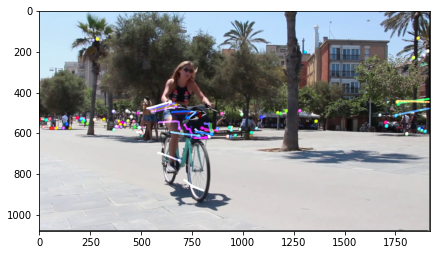

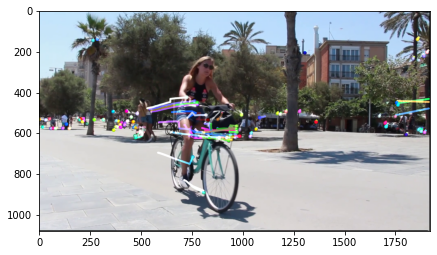

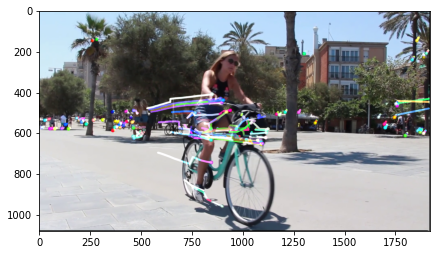

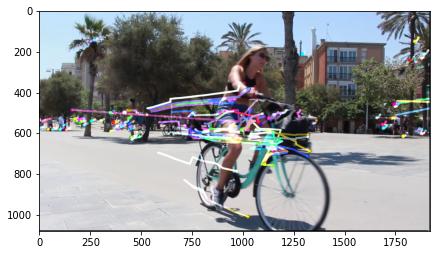

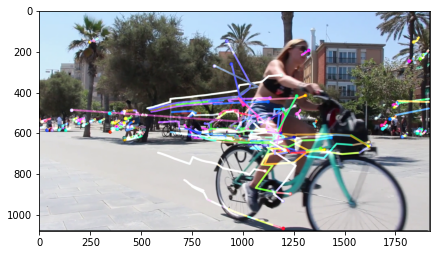

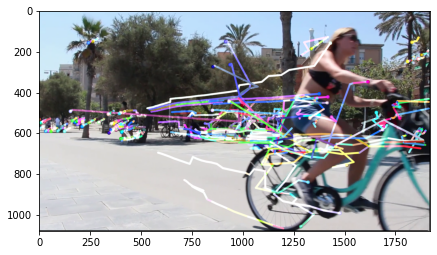

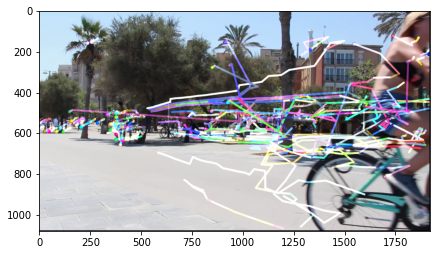

In [7]:
while True:
    _, frame_2 = bike.read()
    frame_2_gray = cv.cvtColor(frame_2, cv.COLOR_BGR2GRAY)
    count += 1

    keypoints_2, status, _ = cv.calcOpticalFlowPyrLK(
        frame_1_gray, frame_2_gray, keypoints_1, None, winSize=(15, 15),
        maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    keypoints_2_good = keypoints_2[status==1]
    keypoints_1_good = keypoints_1[status==1]
    
    for i, (kp2, kp1) in enumerate(zip(keypoints_2_good, keypoints_1_good)):
        a, b = kp2.ravel()
        a, b = int(a), int(b)
        c, d = kp1.ravel()
        c, d = int(c), int(d)
        cv.line(mask, (a, b), (c, d), corners_colors[i].tolist(), 8, cv.LINE_AA)
        cv.circle(frame_2, (a ,b), 9, corners_colors[i].tolist(), -1)
    
    display_frame = cv.add(frame_2, mask)
    if count % 5 == 0:
        plt.figure(figsize=(7,7))
        plt.imshow(display_frame[:,:,::-1])
    if count > 40:
        break

    frame_1_gray = frame_2_gray.copy()
    keypoints_1 = keypoints_2_good.reshape(-1,1,2)
    
bike.release()

Możemy zauważyć, że część punktów kluczowych została wykryta poza głównym śledzonym obiektem, jednak mimo wszystko jesteśmy w stanie określić główny ruch przemieszczającego się obiektu.

## Stabilizacja obrazu

Spróbujemy wykorzystać przepływ optyczny do stablizacji cyfrowej filmu nakręconego z ręki:

In [8]:
IPython.display.Video("vid/protest.mp4", width=800)

Załadujmy film oraz przygotujmy film wyjściowy, który będziemy wyświetlać obok oryginalnego, tak aby móc porównać otrzymane wyniki:

In [9]:
cap = cv.VideoCapture("vid/protest.mp4")
n_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH)) 
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv.CAP_PROP_FPS)

out = cv.VideoWriter('vid/gen-protest.avi', cv.VideoWriter_fourcc(*'MJPG'), fps, (width*2, height))

Pomiędzy poszczególnymi klatkami filmu znajdujemy punkty kluczowe i śledzimy w jaki sposób się one przemieściły. Na tej podstawie przy pomocy [`cv.estimateAffinePartial2D()`](https://docs.opencv.org/4.5.3/d9/d0c/group__calib3d.html#gad767faff73e9cbd8b9d92b955b50062d) możemy oszacować transformacje (translację oraz obrót), które nastapiły między następującymi po sobie klatkami:

In [10]:
_, prev = cap.read()
prev_gray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)

transforms = np.zeros((n_frames-1, 3), np.float32)

for i in range(n_frames-2):
    prev_pts = cv.goodFeaturesToTrack(prev_gray, maxCorners=200,
                                      qualityLevel=0.01, minDistance=30, blockSize=3)
      
    success, curr = cap.read() 
    if not success: 
        break
    curr_gray = cv.cvtColor(curr, cv.COLOR_BGR2GRAY) 
    
    curr_pts, status, _ = cv.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]
    
    mat, _ = cv.estimateAffinePartial2D(prev_pts, curr_pts)
    # traslation
    dx = mat[0,2]
    dy = mat[1,2]
    # rotation angle
    da = np.arctan2(mat[1,0], mat[0,0])
    
    transforms[i] = [dx,dy,da]
      
    prev_gray = curr_gray

Przygotujemy też kilka funkcji pomocniczych. Posiadając serię transformacji wygładzimy ich poszczególne komponenty przy pomocy średniej kroczącej.

In [11]:
def moving_average(values, radius): 
    window_size = 2 * radius + 1    
    mask = np.ones(window_size)/window_size 

    values_padded = np.lib.pad(values, (radius, radius), 'edge') 
    values_smoothed = np.convolve(values_padded, mask, mode='same') 
     
    return values_smoothed[radius:-radius] # remove padding

def smooth(trajectory, radius=50): 
    smoothed_trajectory = np.copy(trajectory) 
    for i in range(smoothed_trajectory.shape[1]):
        smoothed_trajectory[:,i] = moving_average(trajectory[:,i], radius)

    return smoothed_trajectory

Możemy teraz policzyć jakie mieliśmy transformacje względem początku filmu, wygładzić je poprzez średnią kroczącą, a następnie nanieść wynikowe różnice na poszczególne transformacje:

In [12]:
trajectory = np.cumsum(transforms, axis=0)
smoothed_trajectory = smooth(trajectory) 

difference = smoothed_trajectory - trajectory
transforms_smooth = transforms + difference

Ostatecznie na podstawie wygładzonych transformacji dostosowujemy poszczególne klatki filmu. Dodatkowo poprzez ustabilizowanie obrazu mogą pojawić się czarne obramowania na wynikowym obrazie, zatem poprzez niewielkie powiększenie obrazu zniwelujemy ten efekt:

In [13]:
cap.set(cv.CAP_PROP_POS_FRAMES, 0) # back to first frame

for i in range(5-2):
    success, frame = cap.read() 
    if not success:
        break

    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]

    mat = np.zeros((2,3), np.float32)
    mat[0,0] = np.cos(da)
    mat[0,1] = -np.sin(da)
    mat[1,0] = np.sin(da)
    mat[1,1] = np.cos(da)
    mat[0,2] = dx
    mat[1,2] = dy

    frame_stabilized = cv.warpAffine(frame, mat, (width, height))
    
    mat = cv.getRotationMatrix2D((width/2, height/2), 0, 1.1)
    frame_stabilized = cv.warpAffine(frame_stabilized, mat, (width, height))

    frame_out = cv.hconcat([frame, frame_stabilized]) # frame by frame
    
    out.write(frame_out)
    
out.release()

Na potrzeby wyświetlenie wynikowego filmu w przeglądarce, użyjemy kodeka H264:

In [14]:
!ffmpeg -y -hide_banner -loglevel warning -nostats -i vid/gen-protest.avi -vcodec libx264 vid/gen-protest.mp4

Wynikowy film:

In [15]:
IPython.display.Video("vid/gen-protest.mp4", width=800, embed=True)

# Śledzenie obiektów

Załóżmy, że chcemy na poniższym filmie śledzić przemieszczanie się piłkarek:

In [16]:
IPython.display.Video("vid/football.mp4", width=800)

Biblioteka OpenCV posiada [kilka algorytmów](https://docs.opencv.org/4.5.3/dc/d6b/group__tracking__legacy.html) pozwalających na śledzenie obiektów. Poniżej użyjemy algorytmu [*Multiple Instance Learning*](https://docs.opencv.org/4.5.3/d9/dbc/classcv_1_1legacy_1_1TrackerMIL.html):

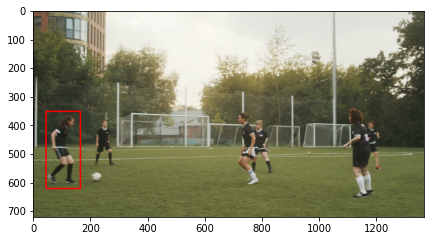

In [17]:
video = cv.VideoCapture("vid/football.mp4")
_, frame = video.read()

bbox = (45, 350, 120, 270)

tracker = cv.legacy.TrackerMIL_create()
tracker.init(frame, bbox)

pt_1 = (int(bbox[0]), int(bbox[1]))
pt_2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv.rectangle(frame, pt_1, pt_2, (0, 0, 255), 4, cv.LINE_8)

plt.figure(figsize=(7,7))
plt.imshow(frame[:,:,::-1]);

Możemy sprawdzić wyniki pomiędzy poszczególnymi klatkami, jednak tutaj na potrzeby prezentacji dodajmy odstęp co 10 klatek aby można było zauwazyć ruch. Dodatkowo możemy sprawdzić względną prędkość działania algorytmu:

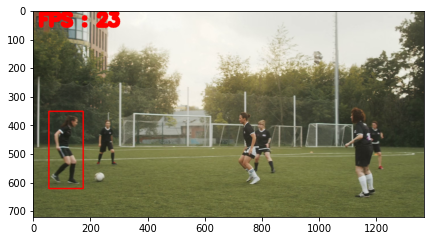

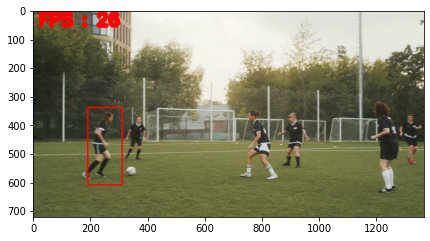

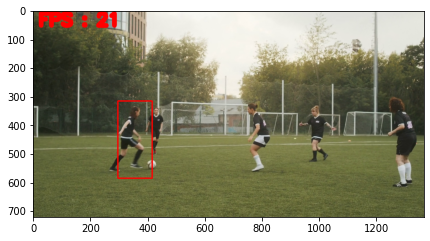

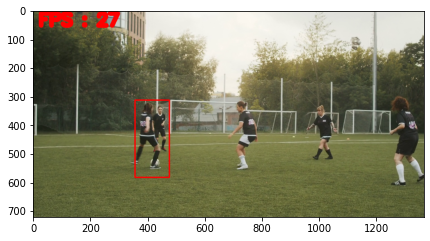

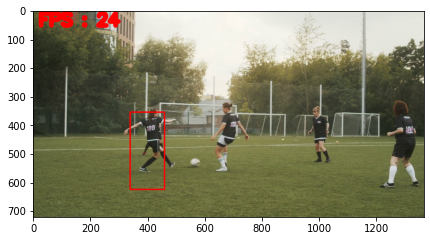

In [18]:
count = 50

while count > 0:

    ok, frame = video.read()
    if not ok:
        break

    timer = cv.getTickCount()
    
    ok, bbox = tracker.update(frame)
    
    fps = cv.getTickFrequency() / (cv.getTickCount() - timer);

    if ok:
        pt_1 = (int(bbox[0]), int(bbox[1]))
        pt_2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv.rectangle(frame, pt_1, pt_2, (0,0,255), 4, cv.LINE_8)
    else :
        cv.putText(frame, "Tracking failure", (20, 180), 
                    cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), cv.LINE_AA)

    cv.putText(frame, "FPS : " + str(int(fps)), (20,50), 
               cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), cv.LINE_AA)

    if count % 10 == 0:
        plt.figure(figsize=(7,7))
        plt.imshow(frame[:,:,::-1])
    count -= 1

video.release()

Istnieje też możliwość jednoczesnego śledzenia kilku obiektów:

In [19]:
video = cv.VideoCapture("vid/football.mp4")
_, frame = video.read()

bboxes = [(45, 350, 120, 270), (755, 350, 120, 270)]
colors = [(0, 0, 255), (0, 255, 0)]

multi_tracker = cv.legacy.MultiTracker_create()

for bbox in bboxes:
    multi_tracker.add(cv.legacy.TrackerMIL_create(), frame, bbox)

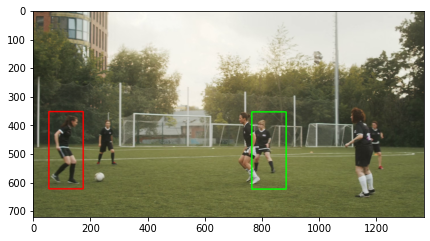

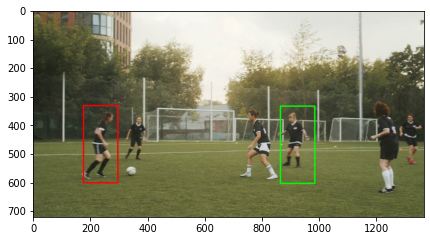

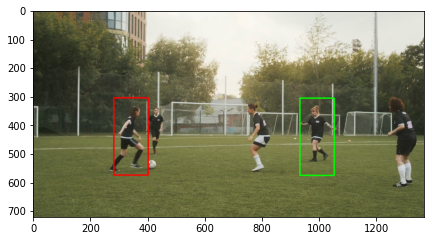

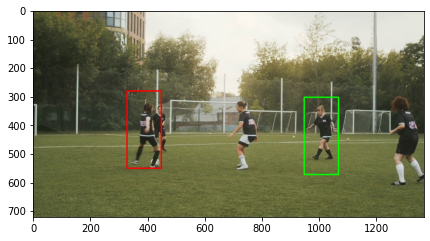

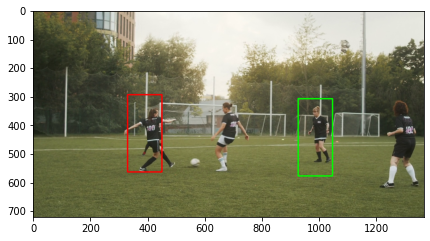

In [20]:
count = 50

while count > 0:

    ok, frame = video.read()
    if not ok:
        break

    timer = cv.getTickCount()
    
    _, boxes = multi_tracker.update(frame)
    
    for i, bbox in enumerate(boxes):
        pt_1 = (int(bbox[0]), int(bbox[1]))
        pt_2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv.rectangle(frame, pt_1, pt_2, colors[i], 4, cv.LINE_8)

    if count % 10 == 0:
        plt.figure(figsize=(7,7))
        plt.imshow(frame[:,:,::-1])
    count -= 1

video.release()

# Zadanie 1

Dla filmu `vid/football.mp4` porównaj jakość śledzenia dla dostępnych algorytmów. Wyniki zapisz na jednym filmie.

![Porówanie algorytmów śledzenia obiektów](img/football-multi.png)

In [21]:
video = cv.VideoCapture("vid/football.mp4")
_, frame = video.read()

trackers = []
bbox = (45, 350, 120, 270)

tracker_mil = cv.legacy.TrackerMIL_create()
tracker_mil.init(frame, bbox)
trackers.append((tracker_mil, 'MIL'))

tracker_b = cv.legacy.TrackerBoosting_create()
tracker_b.init(frame, bbox)
trackers.append((tracker_b, 'BOOSTING'))

tracker_kcf = cv.legacy.TrackerKCF_create()
tracker_kcf.init(frame, bbox)
trackers.append((tracker_kcf, 'KCF'))

tracker_tld = cv.legacy.TrackerTLD_create()
tracker_tld.init(frame, bbox)
trackers.append((tracker_tld, 'TLD'))

tracker_mf = cv.legacy.TrackerMedianFlow_create()
tracker_mf.init(frame, bbox)
trackers.append((tracker_mf, 'MEDIANFLOW'))

tracker_m = cv.legacy.TrackerMOSSE_create()
tracker_m.init(frame, bbox)
trackers.append((tracker_m, 'MOOSE'))

tracker_csrt = cv.legacy.TrackerCSRT_create()
tracker_csrt.init(frame, bbox)
trackers.append((tracker_csrt, 'CSRT'))

In [22]:
cap = cv.VideoCapture("vid/football.mp4")
n_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH)) 
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv.CAP_PROP_FPS)

out = cv.VideoWriter('vid/football_different_algorithms.avi', cv.VideoWriter_fourcc(*'MJPG'), fps, (width, height))

for tracker in trackers:
    video = cv.VideoCapture("vid/football.mp4")

    for _ in range(n_frames-2):
        ok, frame = video.read()
        if not ok:
            break

        ok, bbox = tracker[0].update(frame)

        if ok:
            pt_1 = (int(bbox[0]), int(bbox[1]))
            pt_2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv.rectangle(frame, pt_1, pt_2, (0,0,255), 4, cv.LINE_8)
        else :
            cv.putText(frame, "Tracking failure", (20, 180), 
                        cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), cv.LINE_AA)

        cv.putText(frame, f"{tracker[1]}", (20,50), 
                   cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), cv.LINE_AA)
        out.write(frame)

out.release()
video.release()

In [23]:
!ffmpeg -y -hide_banner -loglevel warning -nostats -i vid/football_different_algorithms.avi -vcodec libx264 vid/football_different_algorithms.mp4

In [24]:
IPython.display.Video("vid/football_different_algorithms.mp4", width=800)